In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
import shap
import joblib

In [60]:
import warnings
warnings.filterwarnings('ignore')

## Load and prepared datasets

In [62]:
# Load the datasets
registration_data_train = pd.read_csv('data/registration_data_training.csv')
previous_lives_data_train = pd.read_csv('data/previous_lives_training_data.csv')
registration_data_test = pd.read_csv('data/registration_data_test.csv')
previous_lives_data_test = pd.read_csv('data/previous_lives_test_data.csv')

In [63]:
registration_data_train

,user_id,registration_time_utc,registration_platform_specific,registration_country,registration_store,registration_season_day,registration_channel_detailed,registration_device_type,registration_device_manufacturer,session_count,...,rests_stash,rests_spent,treatments_spent,morale_spent,money_stash,avg_stars_top_11_players,avg_stars_top_3_players,avg_age_top_11_players,training_count,days_active_first_28_days_after_registration
0,5,2024-05-25 01:26:48.000,iOS Phone,France,AppStore,7,Organic,Phone,Apple,1,...,524,0,0,0,1066076772,4.721867,5.451511,22.0,0,0
1,7,2024-06-14 20:09:31.000,Android Phone,Turkey,GooglePlay,27,Unknown,Phone,Xiaomi,1,...,962,0,0,0,1224446429,4.911067,5.303822,22.0,1,0
2,13,2024-05-31 09:06:51.000,Android Phone,Belarus,GooglePlay,13,Organic,Phone,Xiaomi,2,...,829,0,0,0,1221792142,5.018146,5.746889,24.0,3,0
3,23,2024-05-31 04:00:33.000,Android Phone,Indonesia,GooglePlay,13,Paid,Phone,OPPO,4,...,180,39,12,9,928112709,5.827455,6.692578,22.0,7,1
4,25,2024-06-15 19:56:05.000,iOS Phone,Egypt,AppStore,28,Organic,Phone,Apple,5,...,209,80,0,2,326553498,5.340412,5.775289,24.0,6,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,218943,2024-05-26 13:45:01.000,iOS Phone,Montenegro,AppStore,8,Organic,Phone,Apple,2,...,622,103,0,10,258337268,5.629855,6.038222,24.0,7,10
49996,218947,2024-05-29 08:54:43.000,Android Phone,Indonesia,GooglePlay,11,Unknown,Phone,Xiaomi,2,...,267,0,0,0,1346944347,5.409212,6.129333,24.0,5,0
49997,218948,2024-06-04 05:18:42.000,Android Phone,Indonesia,GooglePlay,17,Organic,Phone,Xiaomi,1,...,601,179,187,68,1049928950,4.975042,5.737466,21.0,0,27
49998,218949,2024-05-27 01:57:37.000,Android Phone,Indonesia,GooglePlay,9,Paid,Phone,realme,3,...,525,0,9,0,1287003702,5.001564,5.835422,22.0,3,23


In [64]:
previous_lives_data_train

,user_id,registration_date,registration_season_day,registration_country,registration_channel_detailed,registration_store,registration_platform_specific,is_payer_lifetime,days_active_lifetime,transaction_count_iap_lifetime,is_rewarded_video_watcher_lifetime
0,5,2022-04-21,26,France,Organic,AppStore,iOS Phone,False,1,0,False
1,5,2023-05-07,15,France,Paid,AppStore,iOS Phone,False,18,0,True
2,7,2022-04-06,11,Turkey,Organic,AppStore,iOS Phone,False,21,0,True
3,7,2023-02-06,9,Turkey,Organic,GooglePlay,Android Phone,False,2,0,False
4,7,2023-05-28,8,Turkey,Unknown,GooglePlay,Android Phone,False,1,0,False
...,...,...,...,...,...,...,...,...,...,...,...
84936,218949,2022-10-15,7,Indonesia,Paid,GooglePlay,Android Phone,False,92,0,False
84937,218956,2022-04-18,23,Indonesia,Paid,GooglePlay,Android Phone,False,12,0,False
84938,218956,2023-02-06,9,Indonesia,Paid,GooglePlay,Android Phone,False,36,0,True
84939,218956,2023-07-08,21,Indonesia,Organic,GooglePlay,Android Phone,False,63,0,True


In [65]:
registration_data_test

,user_id,registration_time_utc,registration_platform_specific,registration_country,registration_store,registration_season_day,registration_channel_detailed,registration_device_type,registration_device_manufacturer,session_count,...,tokens_bought,rests_stash,rests_spent,treatments_spent,morale_spent,money_stash,avg_stars_top_11_players,avg_stars_top_3_players,avg_age_top_11_players,training_count
0,300004,2024-07-04 10:16:58.000,Android Phone,Hungary,GooglePlay,19,Paid,Phone,Xiaomi,8,...,0,910,122,0,22,947426140,5.484873,6.110755,21.0,5
1,300006,2024-06-25 23:04:49.000,iOS Phone,Brazil,AppStore,10,Organic,Phone,Apple,1,...,0,340,6,0,0,706985337,5.202279,5.986044,24.0,3
2,300012,2024-06-17 17:12:37.000,Android Phone,Switzerland,GooglePlay,2,Paid,Phone,OPPO,1,...,0,683,0,0,0,1102920908,4.911588,5.371822,22.0,1
3,300022,2024-06-24 15:29:55.000,Android Phone,Indonesia,GooglePlay,9,Organic,Phone,samsung,1,...,0,555,0,0,0,976796944,5.322267,5.837511,23.0,0
4,300031,2024-06-30 16:09:40.000,Android Phone,Indonesia,GooglePlay,15,Organic,Phone,samsung,1,...,0,556,4,0,0,1049312573,5.720764,6.415555,23.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,512688,2024-06-24 13:51:15.000,Android Phone,Malaysia,GooglePlay,9,Organic,Phone,Xiaomi,3,...,0,448,0,0,0,619653632,5.084376,5.770000,21.0,1
49996,512690,2024-06-20 18:25:52.000,Android Phone,Malaysia,GooglePlay,5,Paid,Phone,samsung,1,...,0,265,4,0,0,956551599,5.362521,6.064711,24.0,0
49997,512702,2024-06-18 19:41:30.000,Android Phone,Indonesia,GooglePlay,3,Paid,Phone,OPPO,4,...,0,494,0,0,0,1065154286,5.153164,6.424756,23.0,4
49998,512712,2024-06-30 13:36:51.000,Android Phone,Indonesia,GooglePlay,15,Organic,Phone,Xiaomi,2,...,0,458,0,0,0,1374426261,3.911176,4.536844,26.0,0


In [66]:
previous_lives_data_test

,user_id,registration_date,registration_season_day,registration_country,registration_channel_detailed,registration_store,registration_platform_specific,is_payer_lifetime,days_active_lifetime,transaction_count_iap_lifetime,is_rewarded_video_watcher_lifetime
0,300004,2022-04-20,25,Switzerland,Organic,GooglePlay,Android Phone,False,5,0,True
1,300004,2023-04-06,12,Finland,Paid,GooglePlay,Android Phone,False,1,0,False
2,300006,2022-06-09,19,Brazil,Organic,AppStore,iOS Phone,False,69,0,True
3,300012,2022-05-25,4,Switzerland,Paid,GooglePlay,Android Phone,False,4,0,False
4,300012,2023-06-13,24,Switzerland,Paid,GooglePlay,Android Phone,False,96,0,True
...,...,...,...,...,...,...,...,...,...,...,...
86108,512712,2022-05-19,26,Indonesia,Organic,GooglePlay,Android Phone,False,401,0,True
86109,512712,2024-01-09,10,Indonesia,Organic,WindowsStore,UniversalWindows PC,False,1,0,False
86110,512713,2022-08-17,4,Myanmar,Organic,GooglePlay,Android Phone,False,1,0,False
86111,512713,2023-02-14,17,Myanmar,Organic,GooglePlay,Android Phone,False,1,0,False


In [67]:
# Merge datasets on 'user_id' for training and testing
train_data = pd.merge(registration_data_train, previous_lives_data_train, on='user_id', how='left')
test_data = pd.merge(registration_data_test, previous_lives_data_test, on='user_id', how='left')


In [68]:
train_data

,user_id,registration_time_utc,registration_platform_specific_x,registration_country_x,registration_store_x,registration_season_day_x,registration_channel_detailed_x,registration_device_type,registration_device_manufacturer,session_count,...,registration_date,registration_season_day_y,registration_country_y,registration_channel_detailed_y,registration_store_y,registration_platform_specific_y,is_payer_lifetime,days_active_lifetime,transaction_count_iap_lifetime,is_rewarded_video_watcher_lifetime
0,5,2024-05-25 01:26:48.000,iOS Phone,France,AppStore,7,Organic,Phone,Apple,1,...,2022-04-21,26,France,Organic,AppStore,iOS Phone,False,1,0,False
1,5,2024-05-25 01:26:48.000,iOS Phone,France,AppStore,7,Organic,Phone,Apple,1,...,2023-05-07,15,France,Paid,AppStore,iOS Phone,False,18,0,True
2,7,2024-06-14 20:09:31.000,Android Phone,Turkey,GooglePlay,27,Unknown,Phone,Xiaomi,1,...,2022-04-06,11,Turkey,Organic,AppStore,iOS Phone,False,21,0,True
3,7,2024-06-14 20:09:31.000,Android Phone,Turkey,GooglePlay,27,Unknown,Phone,Xiaomi,1,...,2023-02-06,9,Turkey,Organic,GooglePlay,Android Phone,False,2,0,False
4,7,2024-06-14 20:09:31.000,Android Phone,Turkey,GooglePlay,27,Unknown,Phone,Xiaomi,1,...,2023-05-28,8,Turkey,Unknown,GooglePlay,Android Phone,False,1,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84936,218949,2024-05-27 01:57:37.000,Android Phone,Indonesia,GooglePlay,9,Paid,Phone,realme,3,...,2022-10-15,7,Indonesia,Paid,GooglePlay,Android Phone,False,92,0,False
84937,218956,2024-06-03 15:25:35.000,Android Phone,Indonesia,GooglePlay,16,Paid,Phone,OPPO,1,...,2022-04-18,23,Indonesia,Paid,GooglePlay,Android Phone,False,12,0,False
84938,218956,2024-06-03 15:25:35.000,Android Phone,Indonesia,GooglePlay,16,Paid,Phone,OPPO,1,...,2023-02-06,9,Indonesia,Paid,GooglePlay,Android Phone,False,36,0,True
84939,218956,2024-06-03 15:25:35.000,Android Phone,Indonesia,GooglePlay,16,Paid,Phone,OPPO,1,...,2023-07-08,21,Indonesia,Organic,GooglePlay,Android Phone,False,63,0,True


In [69]:
test_data

,user_id,registration_time_utc,registration_platform_specific_x,registration_country_x,registration_store_x,registration_season_day_x,registration_channel_detailed_x,registration_device_type,registration_device_manufacturer,session_count,...,registration_date,registration_season_day_y,registration_country_y,registration_channel_detailed_y,registration_store_y,registration_platform_specific_y,is_payer_lifetime,days_active_lifetime,transaction_count_iap_lifetime,is_rewarded_video_watcher_lifetime
0,300004,2024-07-04 10:16:58.000,Android Phone,Hungary,GooglePlay,19,Paid,Phone,Xiaomi,8,...,2022-04-20,25,Switzerland,Organic,GooglePlay,Android Phone,False,5,0,True
1,300004,2024-07-04 10:16:58.000,Android Phone,Hungary,GooglePlay,19,Paid,Phone,Xiaomi,8,...,2023-04-06,12,Finland,Paid,GooglePlay,Android Phone,False,1,0,False
2,300006,2024-06-25 23:04:49.000,iOS Phone,Brazil,AppStore,10,Organic,Phone,Apple,1,...,2022-06-09,19,Brazil,Organic,AppStore,iOS Phone,False,69,0,True
3,300012,2024-06-17 17:12:37.000,Android Phone,Switzerland,GooglePlay,2,Paid,Phone,OPPO,1,...,2022-05-25,4,Switzerland,Paid,GooglePlay,Android Phone,False,4,0,False
4,300012,2024-06-17 17:12:37.000,Android Phone,Switzerland,GooglePlay,2,Paid,Phone,OPPO,1,...,2023-06-13,24,Switzerland,Paid,GooglePlay,Android Phone,False,96,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86108,512712,2024-06-30 13:36:51.000,Android Phone,Indonesia,GooglePlay,15,Organic,Phone,Xiaomi,2,...,2022-05-19,26,Indonesia,Organic,GooglePlay,Android Phone,False,401,0,True
86109,512712,2024-06-30 13:36:51.000,Android Phone,Indonesia,GooglePlay,15,Organic,Phone,Xiaomi,2,...,2024-01-09,10,Indonesia,Organic,WindowsStore,UniversalWindows PC,False,1,0,False
86110,512713,2024-06-29 07:40:23.000,Android Phone,Thailand,GooglePlay,14,Paid,Phone,samsung,1,...,2022-08-17,4,Myanmar,Organic,GooglePlay,Android Phone,False,1,0,False
86111,512713,2024-06-29 07:40:23.000,Android Phone,Thailand,GooglePlay,14,Paid,Phone,samsung,1,...,2023-02-14,17,Myanmar,Organic,GooglePlay,Android Phone,False,1,0,False


## Data Cleaning and Handling Missing Values

In [70]:
# Fill missing values in important columns
train_data['registration_device_manufacturer'].fillna(train_data['registration_device_manufacturer'].mode()[0], inplace=True)
train_data['avg_age_top_11_players'].fillna(train_data['avg_age_top_11_players'].median(), inplace=True)
test_data['registration_device_manufacturer'].fillna(test_data['registration_device_manufacturer'].mode()[0], inplace=True)
test_data['avg_age_top_11_players'].fillna(test_data['avg_age_top_11_players'].median(), inplace=True)

In [71]:
train_data

,user_id,registration_time_utc,registration_platform_specific_x,registration_country_x,registration_store_x,registration_season_day_x,registration_channel_detailed_x,registration_device_type,registration_device_manufacturer,session_count,...,registration_date,registration_season_day_y,registration_country_y,registration_channel_detailed_y,registration_store_y,registration_platform_specific_y,is_payer_lifetime,days_active_lifetime,transaction_count_iap_lifetime,is_rewarded_video_watcher_lifetime
0,5,2024-05-25 01:26:48.000,iOS Phone,France,AppStore,7,Organic,Phone,Apple,1,...,2022-04-21,26,France,Organic,AppStore,iOS Phone,False,1,0,False
1,5,2024-05-25 01:26:48.000,iOS Phone,France,AppStore,7,Organic,Phone,Apple,1,...,2023-05-07,15,France,Paid,AppStore,iOS Phone,False,18,0,True
2,7,2024-06-14 20:09:31.000,Android Phone,Turkey,GooglePlay,27,Unknown,Phone,Xiaomi,1,...,2022-04-06,11,Turkey,Organic,AppStore,iOS Phone,False,21,0,True
3,7,2024-06-14 20:09:31.000,Android Phone,Turkey,GooglePlay,27,Unknown,Phone,Xiaomi,1,...,2023-02-06,9,Turkey,Organic,GooglePlay,Android Phone,False,2,0,False
4,7,2024-06-14 20:09:31.000,Android Phone,Turkey,GooglePlay,27,Unknown,Phone,Xiaomi,1,...,2023-05-28,8,Turkey,Unknown,GooglePlay,Android Phone,False,1,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84936,218949,2024-05-27 01:57:37.000,Android Phone,Indonesia,GooglePlay,9,Paid,Phone,realme,3,...,2022-10-15,7,Indonesia,Paid,GooglePlay,Android Phone,False,92,0,False
84937,218956,2024-06-03 15:25:35.000,Android Phone,Indonesia,GooglePlay,16,Paid,Phone,OPPO,1,...,2022-04-18,23,Indonesia,Paid,GooglePlay,Android Phone,False,12,0,False
84938,218956,2024-06-03 15:25:35.000,Android Phone,Indonesia,GooglePlay,16,Paid,Phone,OPPO,1,...,2023-02-06,9,Indonesia,Paid,GooglePlay,Android Phone,False,36,0,True
84939,218956,2024-06-03 15:25:35.000,Android Phone,Indonesia,GooglePlay,16,Paid,Phone,OPPO,1,...,2023-07-08,21,Indonesia,Organic,GooglePlay,Android Phone,False,63,0,True


In [72]:
test_data

,user_id,registration_time_utc,registration_platform_specific_x,registration_country_x,registration_store_x,registration_season_day_x,registration_channel_detailed_x,registration_device_type,registration_device_manufacturer,session_count,...,registration_date,registration_season_day_y,registration_country_y,registration_channel_detailed_y,registration_store_y,registration_platform_specific_y,is_payer_lifetime,days_active_lifetime,transaction_count_iap_lifetime,is_rewarded_video_watcher_lifetime
0,300004,2024-07-04 10:16:58.000,Android Phone,Hungary,GooglePlay,19,Paid,Phone,Xiaomi,8,...,2022-04-20,25,Switzerland,Organic,GooglePlay,Android Phone,False,5,0,True
1,300004,2024-07-04 10:16:58.000,Android Phone,Hungary,GooglePlay,19,Paid,Phone,Xiaomi,8,...,2023-04-06,12,Finland,Paid,GooglePlay,Android Phone,False,1,0,False
2,300006,2024-06-25 23:04:49.000,iOS Phone,Brazil,AppStore,10,Organic,Phone,Apple,1,...,2022-06-09,19,Brazil,Organic,AppStore,iOS Phone,False,69,0,True
3,300012,2024-06-17 17:12:37.000,Android Phone,Switzerland,GooglePlay,2,Paid,Phone,OPPO,1,...,2022-05-25,4,Switzerland,Paid,GooglePlay,Android Phone,False,4,0,False
4,300012,2024-06-17 17:12:37.000,Android Phone,Switzerland,GooglePlay,2,Paid,Phone,OPPO,1,...,2023-06-13,24,Switzerland,Paid,GooglePlay,Android Phone,False,96,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86108,512712,2024-06-30 13:36:51.000,Android Phone,Indonesia,GooglePlay,15,Organic,Phone,Xiaomi,2,...,2022-05-19,26,Indonesia,Organic,GooglePlay,Android Phone,False,401,0,True
86109,512712,2024-06-30 13:36:51.000,Android Phone,Indonesia,GooglePlay,15,Organic,Phone,Xiaomi,2,...,2024-01-09,10,Indonesia,Organic,WindowsStore,UniversalWindows PC,False,1,0,False
86110,512713,2024-06-29 07:40:23.000,Android Phone,Thailand,GooglePlay,14,Paid,Phone,samsung,1,...,2022-08-17,4,Myanmar,Organic,GooglePlay,Android Phone,False,1,0,False
86111,512713,2024-06-29 07:40:23.000,Android Phone,Thailand,GooglePlay,14,Paid,Phone,samsung,1,...,2023-02-14,17,Myanmar,Organic,GooglePlay,Android Phone,False,1,0,False


## Encode Categorical Variables

In [73]:
# Encode categorical columns using LabelEncoder for both training and test data
categorical_columns = train_data.select_dtypes(include=['object']).columns.difference(['registration_time_utc', 'registration_date'])
label_encoders = {}

for column in categorical_columns:
    le = LabelEncoder()
    train_data[column] = le.fit_transform(train_data[column])
    label_encoders[column] = le
    test_data[column] = test_data[column].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

In [74]:
# Convert boolean columns to integers for consistency
bool_columns = train_data.select_dtypes(include=['bool']).columns
train_data[bool_columns] = train_data[bool_columns].astype(int)
test_data[bool_columns] = test_data[bool_columns].astype(int)

In [75]:
# Drop datetime columns that are not needed for modeling
train_data.drop(columns=['registration_time_utc', 'registration_date'], inplace=True)
test_data.drop(columns=['registration_time_utc', 'registration_date'], inplace=True)

In [76]:
train_data

,user_id,registration_platform_specific_x,registration_country_x,registration_store_x,registration_season_day_x,registration_channel_detailed_x,registration_device_type,registration_device_manufacturer,session_count,playtime,...,days_active_first_28_days_after_registration,registration_season_day_y,registration_country_y,registration_channel_detailed_y,registration_store_y,registration_platform_specific_y,is_payer_lifetime,days_active_lifetime,transaction_count_iap_lifetime,is_rewarded_video_watcher_lifetime
0,5,5,56,0,7,0,1,13,1,141062,...,0,26,56,0,0,5,0,1,0,0
1,5,5,56,0,7,0,1,13,1,141062,...,0,15,56,1,0,5,0,18,0,1
2,7,0,169,3,27,2,1,136,1,521754,...,0,11,172,0,0,5,0,21,0,1
3,7,0,169,3,27,2,1,136,1,521754,...,0,9,172,0,2,0,0,2,0,0
4,7,0,169,3,27,2,1,136,1,521754,...,0,8,172,2,2,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84936,218949,0,79,3,9,1,1,156,3,2016452,...,23,7,79,1,2,0,0,92,0,0
84937,218956,0,79,3,16,1,1,88,1,1468865,...,9,23,79,1,2,0,0,12,0,0
84938,218956,0,79,3,16,1,1,88,1,1468865,...,9,9,79,1,2,0,0,36,0,1
84939,218956,0,79,3,16,1,1,88,1,1468865,...,9,21,79,0,2,0,0,63,0,1


In [77]:
test_data

,user_id,registration_platform_specific_x,registration_country_x,registration_store_x,registration_season_day_x,registration_channel_detailed_x,registration_device_type,registration_device_manufacturer,session_count,playtime,...,training_count,registration_season_day_y,registration_country_y,registration_channel_detailed_y,registration_store_y,registration_platform_specific_y,is_payer_lifetime,days_active_lifetime,transaction_count_iap_lifetime,is_rewarded_video_watcher_lifetime
0,300004,0,76,3,19,1,1,136,8,1450515,...,5,25,164,0,2,0,0,5,0,1
1,300004,0,76,3,19,1,1,136,8,1450515,...,5,12,55,1,2,0,0,1,0,0
2,300006,5,23,0,10,0,1,13,1,3079686,...,3,19,23,0,0,5,0,69,0,1
3,300012,0,161,3,2,1,1,88,1,251649,...,1,4,164,1,2,0,0,4,0,0
4,300012,0,161,3,2,1,1,88,1,251649,...,1,24,164,1,2,0,0,96,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86108,512712,0,79,3,15,0,1,136,2,407971,...,0,26,79,0,2,0,0,401,0,1
86109,512712,0,79,3,15,0,1,136,2,407971,...,0,10,79,0,5,2,0,1,0,0
86110,512713,0,165,3,14,1,1,159,1,621984,...,1,4,120,0,2,0,0,1,0,0
86111,512713,0,165,3,14,1,1,159,1,621984,...,1,17,120,0,2,0,0,1,0,0


## Feature Engineering

In [78]:
# Interaction and new features based on domain knowledge and EDA insights
train_data['playtime_avg_stars_interaction'] = train_data['playtime'] * train_data['avg_stars_top_11_players']
test_data['playtime_avg_stars_interaction'] = test_data['playtime'] * test_data['avg_stars_top_11_players']

In [79]:
# Categorize playtime into levels
train_data['playtime_category'] = pd.cut(train_data['playtime'], bins=[0, 1e6, 5e6, 1e7, np.inf], labels=['low', 'medium', 'high', 'very_high'])
test_data['playtime_category'] = pd.cut(test_data['playtime'], bins=[0, 1e6, 5e6, 1e7, np.inf], labels=['low', 'medium', 'high', 'very_high'])

In [80]:
# High-Engagement Indicator
train_data['high_engagement'] = ((train_data['session_count'] > 5) & (train_data['playtime'] > 1e6)).astype(int)
test_data['high_engagement'] = ((test_data['session_count'] > 5) & (test_data['playtime'] > 1e6)).astype(int)

In [81]:
train_data

,user_id,registration_platform_specific_x,registration_country_x,registration_store_x,registration_season_day_x,registration_channel_detailed_x,registration_device_type,registration_device_manufacturer,session_count,playtime,...,registration_channel_detailed_y,registration_store_y,registration_platform_specific_y,is_payer_lifetime,days_active_lifetime,transaction_count_iap_lifetime,is_rewarded_video_watcher_lifetime,playtime_avg_stars_interaction,playtime_category,high_engagement
0,5,5,56,0,7,0,1,13,1,141062,...,0,0,5,0,1,0,0,6.660760e+05,low,0
1,5,5,56,0,7,0,1,13,1,141062,...,1,0,5,0,18,0,1,6.660760e+05,low,0
2,7,0,169,3,27,2,1,136,1,521754,...,0,0,5,0,21,0,1,2.562369e+06,low,0
3,7,0,169,3,27,2,1,136,1,521754,...,0,2,0,0,2,0,0,2.562369e+06,low,0
4,7,0,169,3,27,2,1,136,1,521754,...,2,2,0,0,1,0,0,2.562369e+06,low,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84936,218949,0,79,3,9,1,1,156,3,2016452,...,1,2,0,0,92,0,0,1.008541e+07,medium,0
84937,218956,0,79,3,16,1,1,88,1,1468865,...,1,2,0,0,12,0,0,9.050897e+06,medium,0
84938,218956,0,79,3,16,1,1,88,1,1468865,...,1,2,0,0,36,0,1,9.050897e+06,medium,0
84939,218956,0,79,3,16,1,1,88,1,1468865,...,0,2,0,0,63,0,1,9.050897e+06,medium,0


In [82]:
test_data

,user_id,registration_platform_specific_x,registration_country_x,registration_store_x,registration_season_day_x,registration_channel_detailed_x,registration_device_type,registration_device_manufacturer,session_count,playtime,...,registration_channel_detailed_y,registration_store_y,registration_platform_specific_y,is_payer_lifetime,days_active_lifetime,transaction_count_iap_lifetime,is_rewarded_video_watcher_lifetime,playtime_avg_stars_interaction,playtime_category,high_engagement
0,300004,0,76,3,19,1,1,136,8,1450515,...,0,2,0,0,5,0,1,7.955890e+06,medium,1
1,300004,0,76,3,19,1,1,136,8,1450515,...,1,2,0,0,1,0,0,7.955890e+06,medium,1
2,300006,5,23,0,10,0,1,13,1,3079686,...,0,0,5,0,69,0,1,1.602139e+07,medium,0
3,300012,0,161,3,2,1,1,88,1,251649,...,1,2,0,0,4,0,0,1.235996e+06,low,0
4,300012,0,161,3,2,1,1,88,1,251649,...,1,2,0,0,96,0,1,1.235996e+06,low,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86108,512712,0,79,3,15,0,1,136,2,407971,...,0,2,0,0,401,0,1,1.595646e+06,low,0
86109,512712,0,79,3,15,0,1,136,2,407971,...,0,5,2,0,1,0,0,1.595646e+06,low,0
86110,512713,0,165,3,14,1,1,159,1,621984,...,0,2,0,0,1,0,0,3.000594e+06,low,0
86111,512713,0,165,3,14,1,1,159,1,621984,...,0,2,0,0,1,0,0,3.000594e+06,low,0


## Define Target and Set Up Pipeline

In [83]:
# Define target and features
target = 'days_active_first_28_days_after_registration'
X = train_data.drop(columns=[target, 'user_id'])
y = train_data[target]
X_test = test_data.drop(columns=['user_id'])

In [84]:
# Store feature names
feature_names = X.columns

In [85]:
# Define numeric and categorical feature sets
numeric_features = X.select_dtypes(include=[np.number]).columns
categorical_features = ['playtime_category']

In [86]:
# Preprocessor to handle scaling and encoding in a single step
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [ ]:
# Pipeline with preprocessor and model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])

In [88]:
# Fit the pipeline
model_pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['registration_platform_specific_x', 'registration_country_x',
       'registration_store_x', 'registration_season_day_x',
       'registration_channel_detailed_x', 'registration_device_type',
       'registration_device_manufacturer', 'session_count', 'playtime',
       'number_of_devices_us...
       'registration_store_y', 'registration_platform_specific_y',
       'is_payer_lifetime', 'days_active_lifetime',
       'transaction_count_iap_lifetime', 'is_rewarded_video_watcher_lifetime',
       'playtime_avg_stars_interaction', 'high_engagement'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['playtime_category'])])),
                ('model', GradientBoostingRegressor(random_state=42))])

## Model Evaluation with Cross-Validation

In [89]:
# Cross-validation to assess performance
cv_scores = cross_val_score(model_pipeline, X, y, cv=KFold(10, shuffle=True, random_state=42), scoring='neg_mean_absolute_error')
mae_scores = -cv_scores  # Convert to positive Mean Absolute Error

In [90]:
print("Final Cross-Validation Evaluation:")
print(f"Mean MAE (10-Fold CV): {mae_scores.mean():.2f}")
print(f"Standard Deviation of MAE (10-Fold CV): {mae_scores.std():.2f}")

Final Cross-Validation Evaluation:
Mean MAE (10-Fold CV): 5.90
Standard Deviation of MAE (10-Fold CV): 0.05


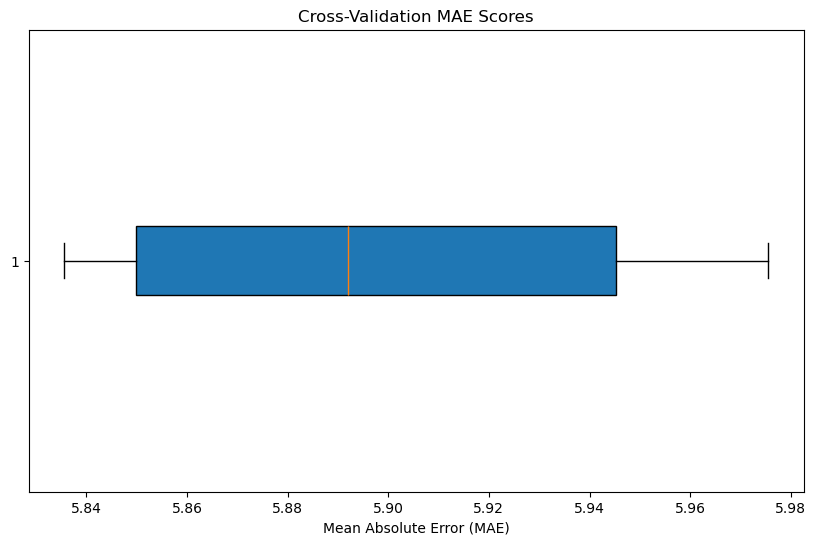

In [94]:
# Visualization of Cross-Validation Scores
plt.figure(figsize=(10, 6))
plt.boxplot(mae_scores, vert=False, patch_artist=True)
plt.title('Cross-Validation MAE Scores')
plt.xlabel('Mean Absolute Error (MAE)')
plt.show()

## Model Explainability with SHAP

In [95]:
# Transform X to match the preprocessed input for SHAP
X_transformed = model_pipeline.named_steps['preprocessor'].transform(X)

In [96]:
# Update feature names to match transformed data
numeric_feature_names = numeric_features
categorical_feature_names = model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
transformed_feature_names = list(numeric_feature_names) + list(categorical_feature_names)

In [97]:
# Initialize SHAP explainer with transformed data
explainer = shap.Explainer(model_pipeline.named_steps['model'], X_transformed)
shap_values = explainer(X_transformed)

 98%|===================| 83466/84941 [00:47<00:00]        

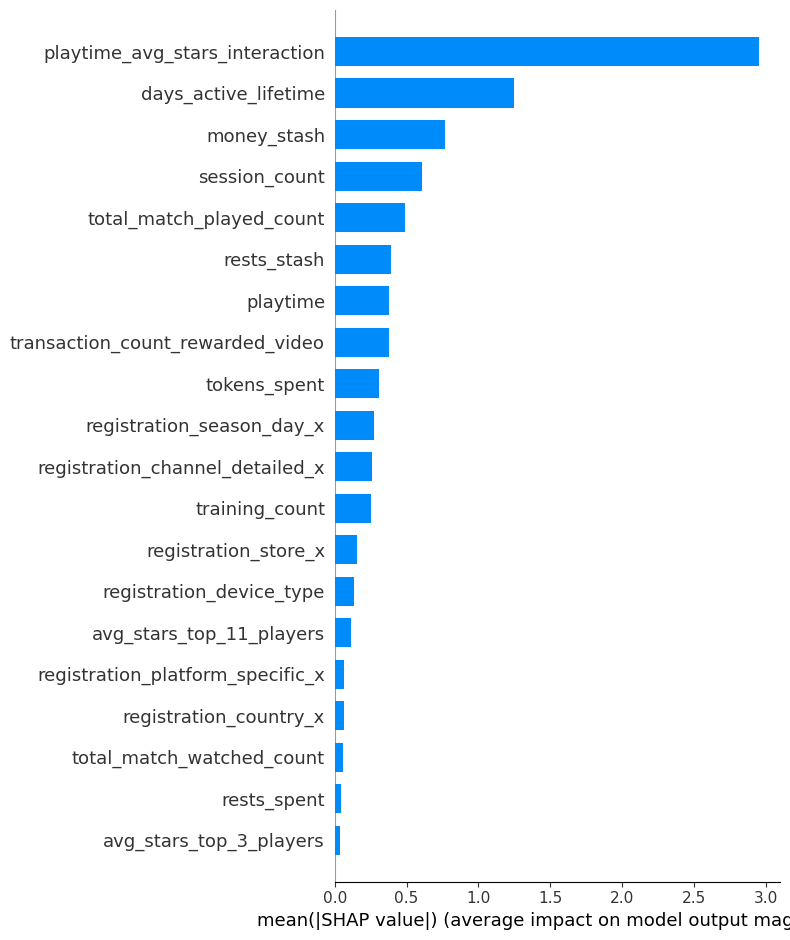

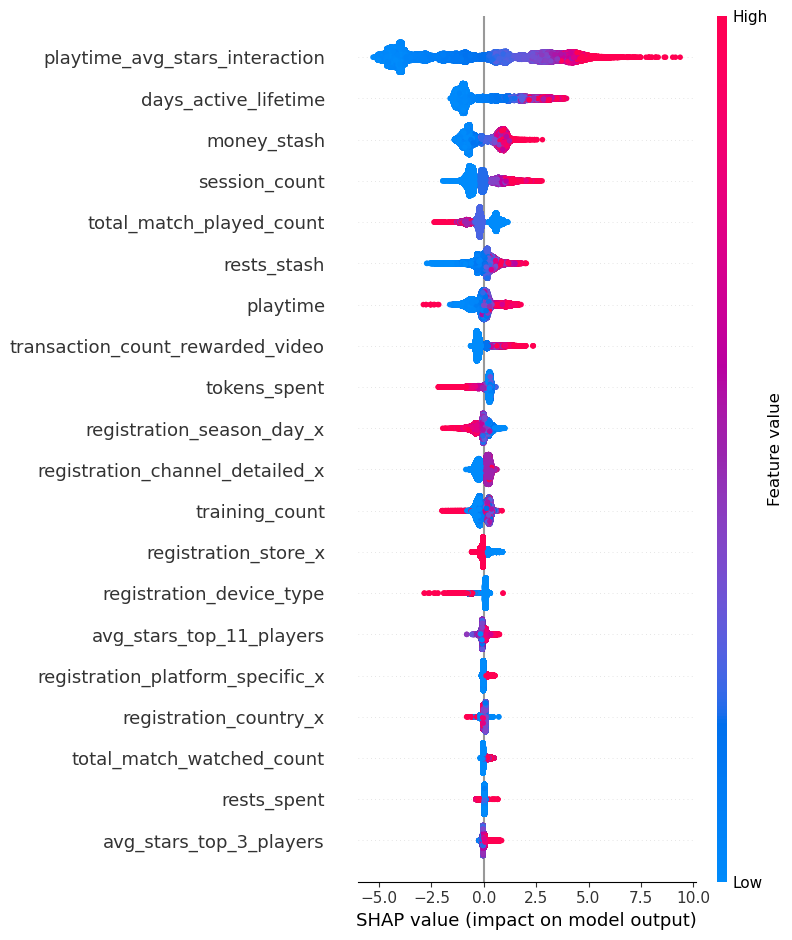

In [98]:
# SHAP summary plot to show feature importance
shap.summary_plot(shap_values, X_transformed, feature_names=transformed_feature_names, plot_type="bar")
shap.summary_plot(shap_values, X_transformed, feature_names=transformed_feature_names)

## Make Predictions

In [99]:
# Make predictions on the test data
predictions = model_pipeline.predict(X_test)

In [100]:
# Clip predictions to ensure they're within the valid range [0, 28]
predictions = np.clip(predictions, 0, 28)

In [101]:
# Prepare submission DataFrame
predictions_df = pd.DataFrame({
    'user_id': test_data['user_id'],
    'predicted_days_active_first_28_days_after_registration': predictions.round().astype(int)
})

In [102]:
predictions_df.head()

,user_id,predicted_days_active_first_28_days_after_registration
0,300004,11
1,300004,11
2,300006,14
3,300012,3
4,300012,5


In [103]:
predictions_df.to_csv('output/days_active_first_28_days_after_registration_predictions.csv', index=False)

In [106]:
joblib.dump(model_pipeline, 'model/output_model.pkl')
print("Model saved.")

Model saved.
